<a href="https://colab.research.google.com/github/katjasit0815/Data-Science-academic-projects/blob/main/04_Bank_Churners%2C_gradient_boosting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost
!pip install lightgbm
!pip install xgboost

In [ ]:
import os
from google.colab import files
import pandas as pd
from math import ceil
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import ceil

from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.compose import make_column_transformer, make_column_selector
import re

from sklearn.model_selection import train_test_split

from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier, log_evaluation
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import log_loss, f1_score, roc_auc_score


from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK, space_eval

import time
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
files.upload()

!pip install --upgrade --quiet kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d "sakshigoyal7/credit-card-customers"
!unzip -q credit-card-customers

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers
License(s): CC0-1.0
  0% 0.00/379k [00:00<?, ?B/s]
100% 379k/379k [00:00<00:00, 762MB/s]


In [ ]:
print(os.listdir())

['.config', 'credit-card-customers.zip', 'BankChurners.csv', 'kaggle.json', 'sample_data']


In [ ]:
pd.set_option('display.max_columns', None)
df = pd.read_csv('BankChurners.csv')
print(df.shape)
df.head()

(10127, 23)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
df = df.drop(df.columns[-2:], axis=1)

In [ ]:
print(df.shape)
df.head()

(10127, 21)


,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
df.info()
print("\nДубликатов строк:", df.duplicated().sum())
print(f'\nРаспределение целевого класса {df["Attrition_Flag"].value_counts()}')
print(f'\nРаспределение в процентах класса {round(df["Attrition_Flag"].value_counts(normalize=True) * 100)}')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

Для моделей XGBoost, LightGBM и AdaBoost перекодируем категориальные признаки:

In [ ]:
print(f"Количество уникальных значений по признакам:\n\n {df.select_dtypes(include='object').nunique()}")

Количество уникальных значений по признакам:

 Attrition_Flag     2
Gender             2
Education_Level    7
Marital_Status     4
Income_Category    6
Card_Category      4
dtype: int64


In [ ]:
for col in ["Attrition_Flag", "Gender"]:      # пол и таргет предварительно кодируем через LabelEncoder,
    le = LabelEncoder()                       # остальные категориальные признаки через OHE
    df[col] = le.fit_transform(df[col])
df.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,768805383,1,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,818770008,1,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,713982108,1,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,769911858,1,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,709106358,1,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
ohe = make_column_transformer(
    (
        OneHotEncoder(sparse_output=False, handle_unknown="ignore"),
        make_column_selector(dtype_include="object"),
    ),
    remainder="passthrough",
)

arr = ohe.fit_transform(df)
raw_names = ohe.get_feature_names_out()
short_names = [re.sub(r'^.*?__', '', name) for name in raw_names]
df_encoded = pd.DataFrame(arr, columns=short_names, index=df.index)

print(df_encoded.shape)
df_encoded.head()

(10127, 38)


,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown,Income_Category_$120K +,Income_Category_$40K - $60K,Income_Category_$60K - $80K,Income_Category_$80K - $120K,Income_Category_Less than $40K,Income_Category_Unknown,Card_Category_Blue,Card_Category_Gold,Card_Category_Platinum,Card_Category_Silver,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,768805383.0,1.0,45.0,1.0,3.0,39.0,5.0,1.0,3.0,12691.0,777.0,11914.0,1.335,1144.0,42.0,1.625,0.061
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,818770008.0,1.0,49.0,0.0,5.0,44.0,6.0,1.0,2.0,8256.0,864.0,7392.0,1.541,1291.0,33.0,3.714,0.105
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,713982108.0,1.0,51.0,1.0,3.0,36.0,4.0,1.0,0.0,3418.0,0.0,3418.0,2.594,1887.0,20.0,2.333,0.000
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,769911858.0,1.0,40.0,0.0,4.0,34.0,3.0,4.0,1.0,3313.0,2517.0,796.0,1.405,1171.0,20.0,2.333,0.760
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,709106358.0,1.0,40.0,1.0,3.0,21.0,5.0,1.0,0.0,4716.0,0.0,4716.0,2.175,816.0,28.0,2.500,0.000


Посмотрим распределения признаков

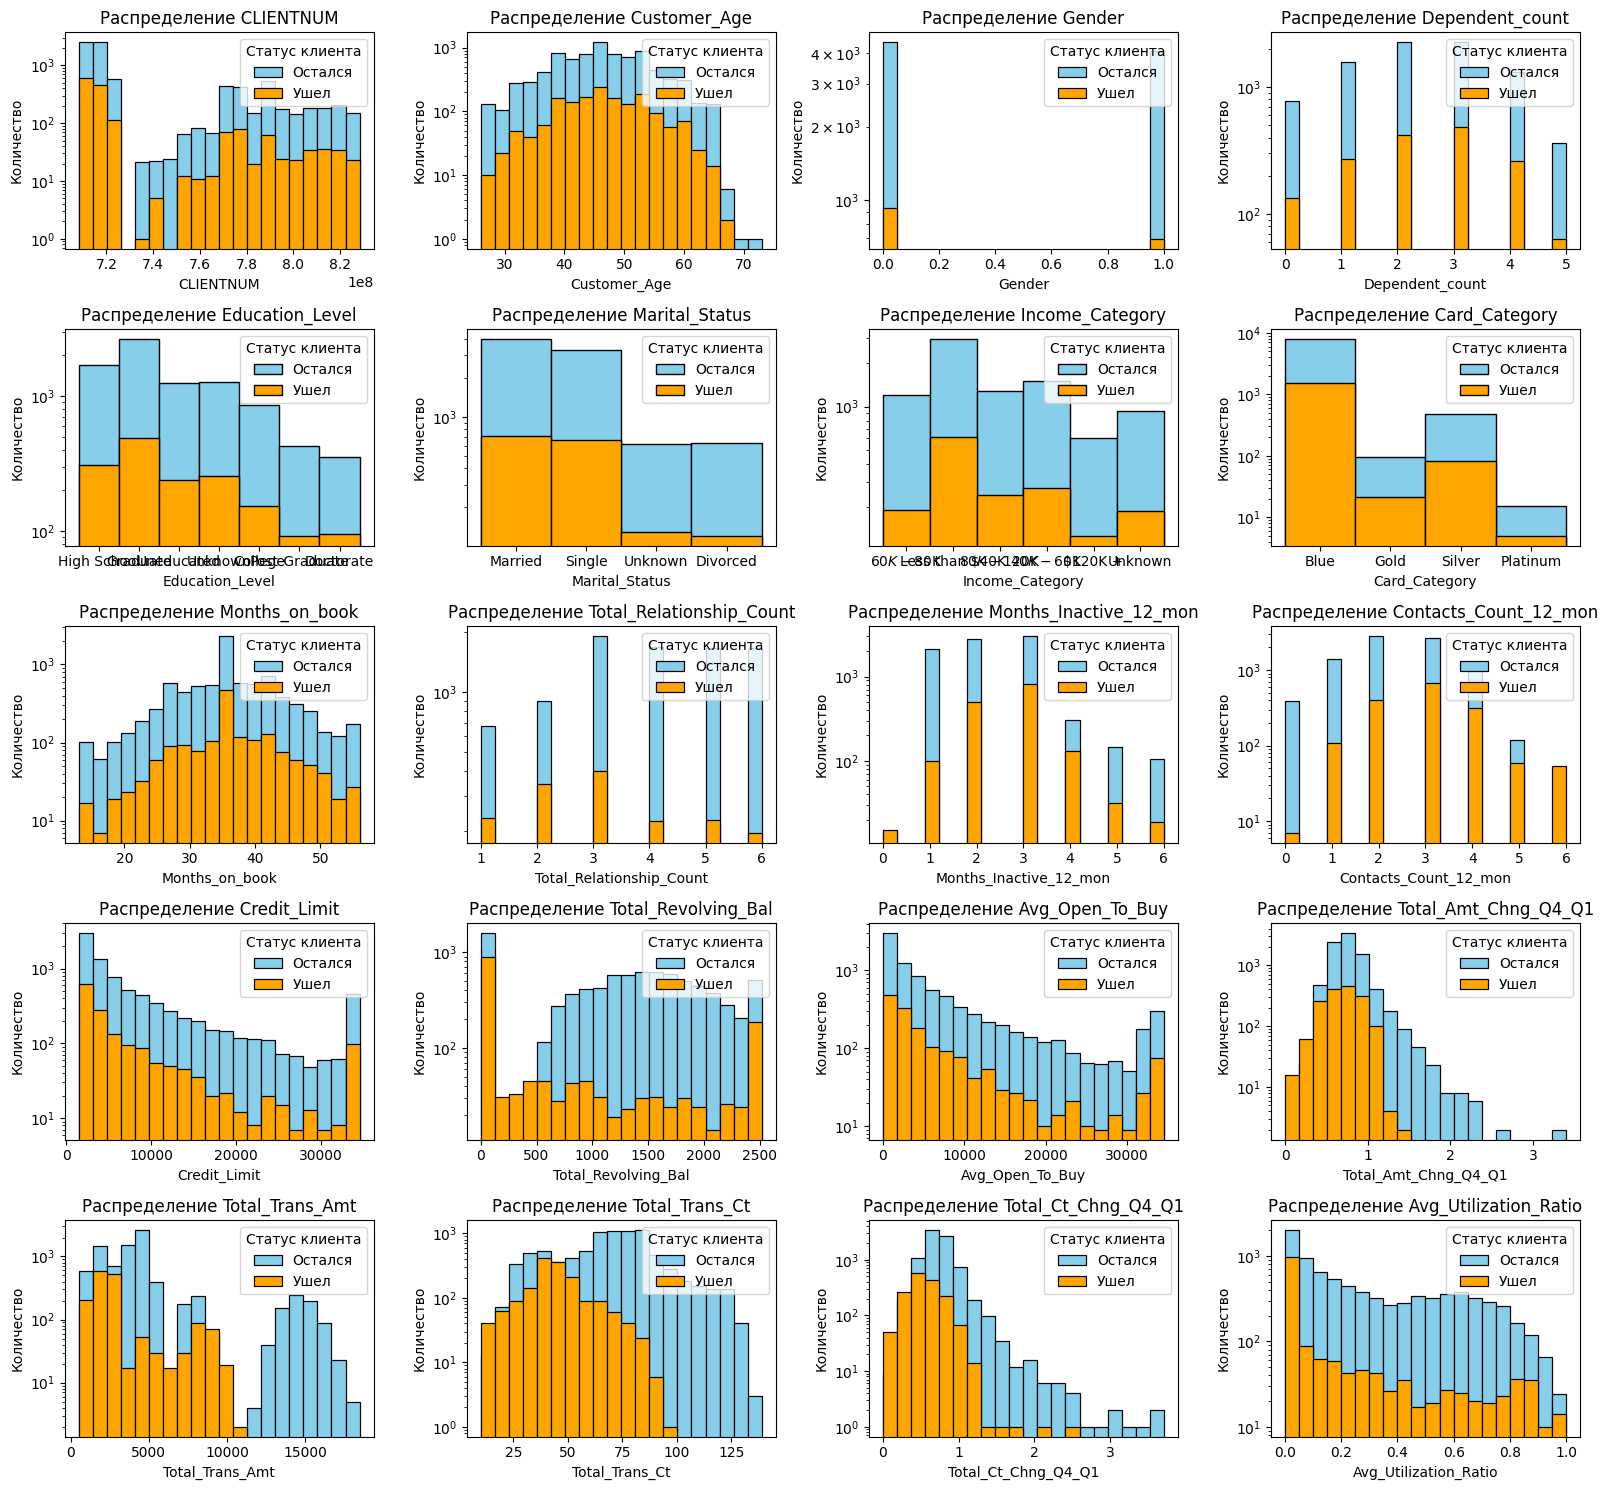

In [ ]:
features = df.columns.drop(['Attrition_Flag'])
n = len(features)
ncols = 4
nrows =ceil(n / ncols)

fig, axes = plt.subplots(
    nrows   = nrows,
    ncols   = ncols,
    figsize = (4 * ncols, 3 * nrows),
    sharey  = False
)
axes = axes.flatten()

for ax, feature in zip(axes, features):
    sns.histplot(
        data    = df,
        x       = feature,
        hue     = 'Attrition_Flag',
        hue_order = [0, 1],
        bins    = 20,
        palette={0:'orange', 1:'skyblue'},
        alpha     = 1.0,
        ax      = ax
    )
    ax.set_title(f'Распределение {feature}')
    ax.set_xlabel(feature)
    ax.set_ylabel('Количество')
    ax.set_yscale('log')
    ax.legend(loc='upper right', title='Статус клиента',labels=['Остался', 'Ушел'])

for ax in axes[len(features):]:
    ax.axis('off')

plt.tight_layout()
plt.show()

Значительные различия у оставшихся и ушедших клиентов наблюдаются на графиках признаков Total_Trans_Amt, Total_Trans_Ct, Total_Ct_Chng_Q4_Q1: видно смещение влево к наименьшим значениям признаков.

<Axes: >

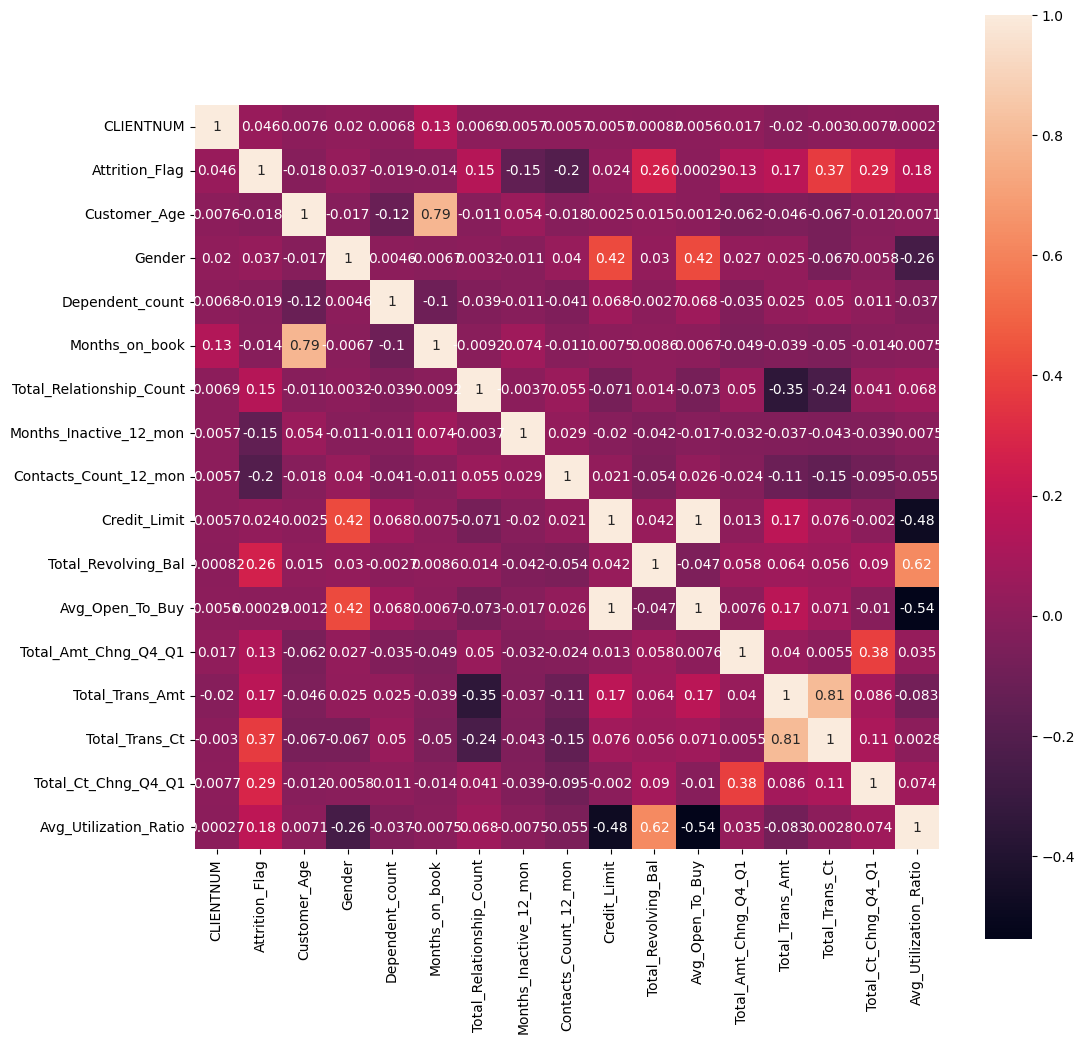

In [ ]:
from matplotlib.pyplot import figure

figure(figsize = (12, 12))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, square=True)

## Обучение моделей

In [ ]:
X = df.drop('Attrition_Flag', axis=1)            # Для CatBoost оставим df с данными до encoding
y = df['Attrition_Flag']

X_enc = df_encoded.drop('Attrition_Flag', axis=1)    # Для обучения других бустингов
y_enc = df_encoded['Attrition_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_enc, X_test_enc, y_train_enc, y_test_enc = train_test_split(X_enc, y_enc, test_size=0.2, random_state=42)

cat_cols = X.select_dtypes(include=['object']).columns.tolist()

In [ ]:
models = {
    "XGBoost": XGBClassifier(verbosity=0, eval_metric="logloss", random_state=42),
    "LightGBM": LGBMClassifier(verbose=-1, random_state=42),
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42)
}

results = []
for name, model in models.items():
    if name == "CatBoost":
        # Передаём cat_cols в cat_features
        model.fit(
            X_train, y_train,
            cat_features=cat_cols,
            eval_set=(X_test, y_test),
            use_best_model=True,
            early_stopping_rounds=20
        )
        proba = model.predict_proba(X_test)
        loss  = log_loss(y_test, proba)
    else:
        model.fit(X_train_enc, y_train_enc)
        proba = model.predict_proba(X_test_enc)
        loss  = log_loss(y_test_enc, proba)

    results.append((name, loss))

results.sort(key=lambda x: x[1])
print("Model       LogLoss")
for name, loss in results:
    print(f"{name:10s} {loss:.4f}")

Model       LogLoss
CatBoost   0.0741
LightGBM   0.0804
XGBoost    0.0935
AdaBoost   0.4887


После грубого сравнения моделей по log loss можно исключить AdaBoost из дальнейшнего подбора гиперпараметров.

Используем библиотеку для оптимизации гиперпараметров Hyperopt для подбора параметров для моделей Catboost, LightGBM, XGBoost.

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Определяем модели с гиперпараметрами для перебора ---
configs = {
    "XGBoost": {
        "balance_method": "auto_balance",
        "make_model": lambda params: XGBClassifier(
            eval_metric='logloss',
            random_state=42,
            **params
        ),
        "space": {
            "n_estimators": hp.choice('xgb_n_estimators', [100, 200, 300, 400]),
            "max_depth": hp.choice('xgb_max_depth', [3,6,9]),
            "learning_rate":hp.loguniform('xgb_lr', np.log(0.01), np.log(0.2)),
        }
    },
    "LightGBM": {
        "balance_method": "auto_balance",
        "make_model": lambda params: LGBMClassifier(
            random_state=42,
            **params
        ),
        "space": {
            "n_estimators": hp.choice('lgb_n_estimators', [100, 200, 300, 400]),
            "num_leaves": hp.choice('lgb_num_leaves', [31,63,127]),
            "learning_rate": hp.loguniform('lgb_lr', np.log(0.01), np.log(0.2)),
        }
    },
    "CatBoost": {
        "make_model": lambda params: CatBoostClassifier(
            random_state=42,
            verbose=False,
            cat_features=cat_cols,
            **params
        ),
        "space": {
            "iterations": hp.choice('cat_iterations', [100, 200, 300, 400]),
            "depth": hp.choice('cat_depth', [4,6,8]),
            "learning_rate": hp.loguniform('cat_lr', np.log(0.01), np.log(0.2)),
            "l2_leaf_reg": hp.choice('cat_l2', [1,3,7]),
        }
    }
}

# Общая функция-тюнер
def tune(name, X, y, cat_features=None, max_evals=30):
    """
    Запускает Hyperopt-поиск гиперпараметров для заданной модели.

    Возвращает:

    best : dict
    Лучшие найденные гиперпараметры (индексы/значения hp.choice).

    trials : Trials
    Объект Trials с полной историей всех попыток.
    """
    cfg = configs[name]
    space = cfg["space"]
    make_model = cfg["make_model"]

    def objective(params):
        """
        Целевая функция для Hyperopt: строит модель,
        проводит CV по F1-score и возвращает {'loss': 1-f1, 'status': STATUS_OK}.
        """
        model = make_model(params)
        cv_results = cross_validate(
            estimator = model,
            X = X,
            y = y,
            cv = cv,
            scoring = 'f1',
            return_train_score=False,
            n_jobs = -1,
        )
        return {'loss': 1 - np.mean(cv_results['test_score']), 'status': STATUS_OK}

    trials = Trials()
    best = fmin(
        fn = objective,
        space = space,
        algo = tpe.suggest,
        max_evals = max_evals,
        trials = trials
    )
    return best, trials

def timed_tune(name, X, y, cat_features=None, max_evals=30):
    """
    Обёртка для tune(), возвращает также время работы в секундах.
    """
    start = time.time()
    best, trials = tune(name, X, y, cat_features=cat_features, max_evals=max_evals)
    elapsed = time.time() - start
    return best, trials, elapsed

#  Запуск тюнинга для каждой модели
best_cat, trials_cat, time_cat = timed_tune("CatBoost", X_train, y_train, cat_features=cat_cols, max_evals=50)
best_xgb, trials_xgb, time_xgb = timed_tune("XGBoost", X_train_enc, y_train_enc, max_evals=50)
best_lgb, trials_lgb, time_lgb = timed_tune("LightGBM", X_train_enc, y_train_enc, max_evals=50)


print("CatB best:", best_cat)
print("XGB best:", best_xgb)
print("LGB best:", best_lgb)


100%|██████████| 50/50 [04:08<00:00,  4.97s/trial, best loss: 0.014054194929234987]
CatB best: {'cat_depth': np.int64(0), 'cat_iterations': np.int64(3), 'cat_l2': np.int64(0), 'cat_lr': np.float64(0.06730983883995781)}
XGB best: {'xgb_lr': np.float64(0.10473672372255051), 'xgb_max_depth': np.int64(0), 'xgb_n_estimators': np.int64(3)}
LGB best: {'lgb_lr': np.float64(0.11537387554404549), 'lgb_n_estimators': np.int64(3), 'lgb_num_leaves': np.int64(0)}


Проведем второй раунд настройки гиперпараметров, проверим варианты, близкие к лучшим.

In [ ]:
configs["XGBoost"]["space"] = {
    "n_estimators": hp.choice('xgb_n_estimators', [150, 180, 200, 225, 250]),
    "max_depth": hp.choice('xgb_max_depth', [2,3,4]),
    "learning_rate":hp.loguniform('xgb_lr', np.log(0.16), np.log(0.25)),
}
configs["LightGBM"]["space"] = {
    "n_estimators": hp.choice('lgb_n_estimators', [350, 400, 500, 600]),
    "num_leaves": hp.choice('lgb_num_leaves', [31,63,127]),
    "learning_rate": hp.loguniform('lgb_lr', np.log(0.05), np.log(0.15)),
}
configs["CatBoost"]["space"] = {
    "iterations": hp.choice('cat_iterations', [250, 275, 300, 325, 350]),
    "depth": hp.choice('cat_depth', [5,6,7]),
    "learning_rate": hp.loguniform('cat_lr', np.log(0.05), np.log(0.15)),
    "l2_leaf_reg": hp.choice('cat_l2', [2,3,4,5]),
}
best_cat2, trials_cat2, _ = timed_tune("CatBoost", X_train, y_train, cat_features=cat_cols, max_evals=70)
best_xgb2, trials_xgb2, _ = timed_tune("XGBoost", X_train_enc, y_train_enc, max_evals=50)
best_lgb2, trials_lgb2, _ = timed_tune("LightGBM", X_train_enc, y_train_enc, max_evals=50)


100%|██████████| 50/50 [05:30<00:00,  6.61s/trial, best loss: 0.014116303828964005]


In [ ]:
real_cat2 = space_eval(configs["CatBoost"]["space"], best_cat2)
real_xgb2 = space_eval(configs["XGBoost"]["space"],  best_xgb2)
real_lgb2 = space_eval(configs["LightGBM"]["space"],  best_lgb2)
for d in (real_cat2, real_xgb2, real_lgb2):
    for k in ("iterations","depth","l2_leaf_reg","n_estimators","max_depth","num_leaves"):
        if k in d: d[k] = int(d[k])
real_xgb2.update({"eval_metric": "logloss"})
real_lgb2.update({"eval_metric": "logloss"})
real_lgb2.update({"verbose": 0})
print("Fine-tuned CatBoost:",   real_cat2)
print("Fine-tuned XGBoost:",    real_xgb2)
print("Fine-tuned LightGBM:",   real_lgb2)

Fine-tuned CatBoost: {'depth': 7, 'iterations': 350, 'l2_leaf_reg': 4, 'learning_rate': 0.0886973607601414}
Fine-tuned XGBoost: {'learning_rate': 0.20591454903267453, 'max_depth': 4, 'n_estimators': 150, 'eval_metric': 'logloss'}
Fine-tuned LightGBM: {'learning_rate': 0.0614300086749553, 'n_estimators': 600, 'num_leaves': 31, 'eval_metric': 'logloss', 'verbose': 0}


In [ ]:
def train_and_predict(
    ModelClass,
    params: dict,
    X_train, y_train,
    X_test,  y_test,
    *,
    cat_features=None,
):
    """
    1) Строит модель с заданным классом и параметрами.
    2) Если cat_features — передаёт их в fit() (для CatBoost).
    3) Возвращает обученную модель, предсказания классов и вероятностей, а также метрики.
    4) Отрисовывает кривые обучения.
    """
    X_tr, X_val, y_tr, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    stratify=y_train,
    random_state=42
)
    model = ModelClass(**params)
    name = ModelClass.__name__
    if name == "CatBoostClassifier":
        train_pool = Pool(X_tr, label=y_tr, cat_features=cat_features)
        val_pool   = Pool(X_val, label=y_val, cat_features=cat_features)
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=False,
            metric_period=1,
            verbose=False
        )
        # model.fit(X_train, y_train, cat_features=cat_features)
        history = model.get_evals_result()
    elif name == "XGBClassifier":
        eval_set = [(X_tr, y_tr), (X_val, y_val)]
        model.fit(
            X_tr, y_tr,
            eval_set=eval_set,
            verbose=False
        )
        history = model.evals_result()
    else:
        callbacks = [log_evaluation(period=0)]
        eval_set = [(X_tr, y_tr), (X_val, y_val)]
        model.fit(
            X_tr, y_tr,
            eval_set=eval_set,
            callbacks=callbacks)
        history = model.evals_result_

    y_pred  = model.predict(X_test)
    try:
        y_proba = model.predict_proba(X_test)[:, 1]
    except AttributeError:
        y_proba = model.predict_proba(X_test)[:, 1]

    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    metrics = {
        'f1':  f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_proba),
    }

    if name == "CatBoostClassifier":
        train_loss = history["learn"]["Logloss"]
        val_loss   = history["validation"]["Logloss"]

    elif name == "XGBClassifier":
        train_loss = history["validation_0"]["logloss"]
        val_loss   = history["validation_1"]["logloss"]

    else:
        train_loss = history["training"]["binary_logloss"]
        val_loss   = history["valid_1"]["binary_logloss"]


    epochs = np.arange(1, len(train_loss)+1)
    plt.figure(figsize=(8,5))
    plt.plot(epochs, train_loss, label='Train Logloss')
    plt.plot(epochs,   val_loss, label='Val   Logloss')
    plt.xlabel('Iteration')
    plt.ylabel('Logloss')
    plt.title(f'Learning Curve: {ModelClass.__name__}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, y_pred, y_proba, metrics

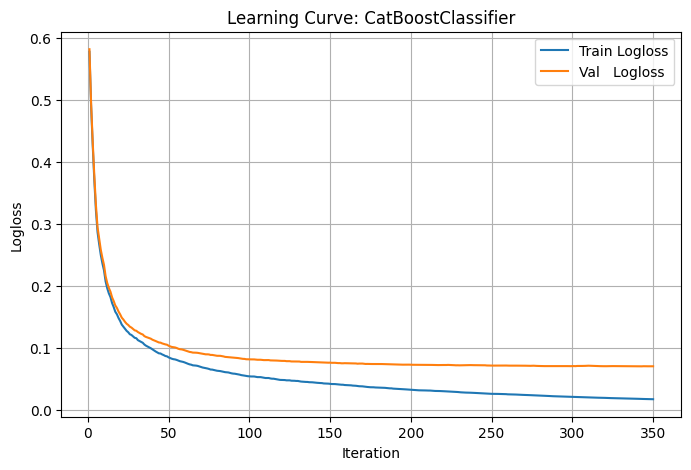

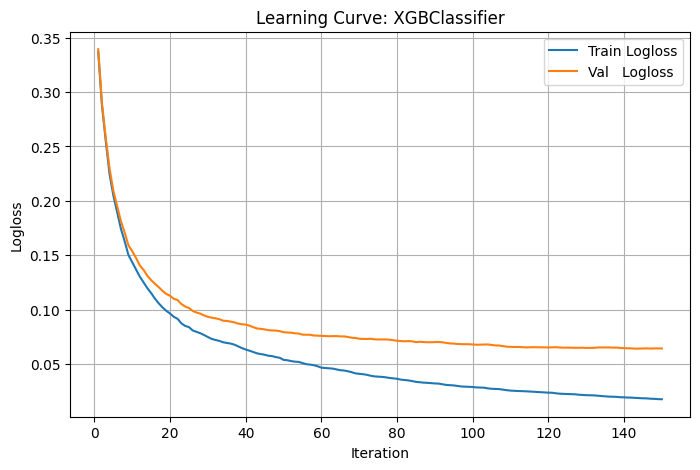

[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric
[LightGBM] [Warning] Unknown parameter: eval_metric


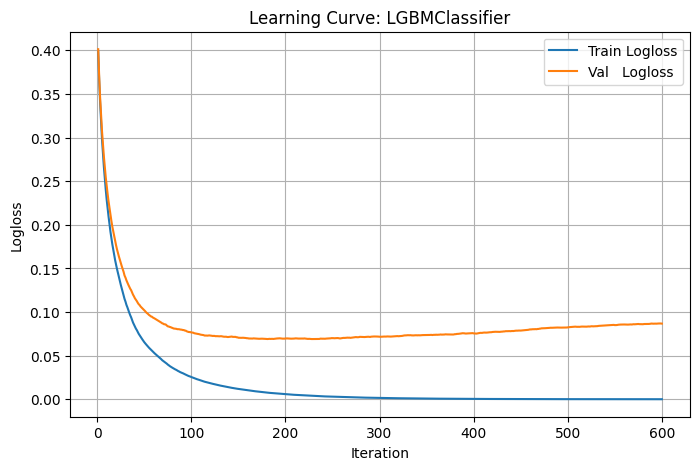

In [ ]:
for c in cat_cols:
    X_train[c] = X_train[c].astype(str)
    X_test[c]  = X_test[c].astype(str)

cat_model, cat_pred, cat_proba, cat_metrics = train_and_predict(
    CatBoostClassifier,
    real_cat2,
    X_train, y_train,
    X_test,  y_test,
    cat_features=cat_cols
)
xgb_model, xgb_pred, xgb_proba, xgb_metrics = train_and_predict(
    XGBClassifier,
    real_xgb2,
    X_train_enc, y_train_enc,
    X_test_enc,  y_test_enc,
)

lgb_model, lgb_pred, lgb_proba, lgb_metrics = train_and_predict(
    LGBMClassifier,
    real_lgb2,
    X_train_enc, y_train_enc,
    X_test_enc,  y_test_enc,
)

In [ ]:
print("CatBoost metrics:", cat_metrics)
print("XGBoost metrics:", xgb_metrics)
print("LightGBM metrics:", lgb_metrics)

CatBoost metrics: {'f1': 0.9794480328831474, 'auc': np.float64(0.9931566148822926)}
XGBoost metrics: {'f1': 0.980058651026393, 'auc': np.float64(0.9928542243773546)}
LightGBM metrics: {'f1': 0.9803346052245377, 'auc': np.float64(0.9930144193472324)}


Можно сделать вывод, что все модели градиентного бустинга справились с задачей одинаково хорошо (результат рознился в зависимости от результатов перебора гиперпараметров на +- 0.01). Отметим, что LGB переучилась и будет достаточно n_etimators = 200.